In [7]:
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

In [2]:
legend = {'-':u'-',
          'Coin':u'o',
          'Goomba':u'g',
          'Ground':u'X',
          'hill_angle_l':u'/',
          'hill_angle_r':u'\\',
          'hill_l':u'{',
          'hill_r':u'}',
          'hill_mid':u' ',
          'pipe':u'[',
          'pipe_r':u']',
          'pipe_ul':u'<',
          'pipe_ur':u'>',
          'bush_l':u'a',
          'bush_r':u'e',
          'bush_m':u'u',
          'stairs':u'#',
          'block':u'H',
          'hammerbro':u'𝐡',
          'question_mushroom':u'?',
          'question_star':u'*',
          'question_1up':u'!',
          'question_block':u'Q',
          'bush_t':u'n',
          'Koopa':u'k',
          'cloud_ul':u'4',
          'cloud_ur':u'6',
          'cloud_um':u'5',
          'cloud_ll':u'1',
          'cloud_lm':u'2',
          'cloud_lr':u'3',
          'coinblock':u'C',
          'hill_top':u'm',
          'Girder':u'&',
          'Pirannha':u'V',
          'Bullet':u'B',
          'buzzy_beetle':u'Ƅ',
          'bullet_base':u'b',
          'red_koopa':u'r',
          'treetop_left':u'‹',
          'treetop_right':u'›',
          'treetop_mid':u'~',
          'mushroom_left':u'‹',
          'mushroom_right':u'›',
          'mushroom_mid':u'~',
          'bark':u'ʜ',
          'flying_red_koopa':u'κ',
          'flying_koopa':u'Ꮶ',
          'mushroom_stem_top':u'∪',
          'mushroom_stem':u'U',
          'treetop':u'^',
          'treebottom':u'v',
          'trunk':u'|',
          'shrub':u'O',
          'fence':u'%',
          'mush_bridge':u'_',
          'snow_treetop':u'^',
          'snow_treebottom':u'v',
          'snow_shrub':u'O',
          'Bridge':u'#',
          'snow_treetop_left':u'‹',
          'snow_treetop_right':u'›',
          'snow_treetop_mid':u'~',
          'spiny':u's'
          }

In [3]:

def findSubImageLocations(image,subImage,confidence):
    allLocations = [ np.array([]) , np.array([])]
    
        
    result = cv2.matchTemplate(image,subImage,cv2.TM_CCOEFF_NORMED)
    match_indices = np.arange(result.size)[(result>confidence).flatten()]

    locations =  np.unravel_index(match_indices,result.shape)
        
       # print locations
    allLocations[0] = np.concatenate((allLocations[0],locations[0]+(subImage.shape[0]-16)))
    allLocations[1] = np.concatenate((allLocations[1],locations[1]))
    return allLocations,  result.ravel()[ match_indices]     


In [4]:
levelname = 'VGLC/Super Mario Bros/Original/mario-1-1.png'
level = cv2.imread(levelname)

tile_path = 'SMBTiles/'
tile_files = [f for f in listdir(tile_path) if isfile(join(tile_path, f))]
sprite2ur = {}
for f in tile_files:
    ind = f.find('-')
    if ind == -1:
        ind = f.index('.')
    sprite2ur[f] = f[:ind]     
               

In [23]:

levelMap = {}

maxX = -1
maxY = -1

levelConf = {}
levelPriority = {}
priority = {sprite2ur[sprite]:0 for sprite in sprite2ur}
for sprite in ['question_mushroom','question_star','coinblock','question_1up']:
    priority[sprite] = 1
sprites = set(['red_koopa','flying_koopa','Koopa','Goomba','hammerbro','flying_red_koopa',
               'Pirannha','Girder','buzzy_beetle','spiny','mushroom_bridge'])



#For all sprites
for sprite in sprite2ur:
    #Find sprite locations and their associated confidences using OpenCV's template matching
    #as a default, only allow those with a confidence >= 0.65 to be considered
    locs,conf = findSubImageLocations(level,cv2.imread(join(tile_path, sprite)),0.55)

    for yy,xx,c in zip(locs[0],locs[1],conf):
        mx = xx/16.
        my = yy/16.

        xx = int(np.round(xx/16.))
        yy = int(np.round(yy/16.))
        #If something is more than 20% off center, only allow it if it is a sprite
        if (abs(xx-mx) > 0.2 or abs(yy-my) > 0.2) and sprite2ur[sprite] not in sprites:
            continue
        #Default to a confidence of -1
        if (xx,yy) not in levelConf:
            
            levelConf[(xx,yy)] = -1
            levelPriority[(xx,yy)] = -1
        #If the current image has higher confidence OR it has priority
        if  c >levelConf[(xx,yy)] and priority[sprite2ur[sprite]] >= levelPriority[(xx,yy)]:
            levelPriority[(xx,yy)] = priority[sprite2ur[sprite]]
            levelConf[(xx,yy)] = c
            levelMap[(xx,yy)] = sprite2ur[sprite]
        #Keep track of level sizes
        maxX = max(maxX,xx)
        maxY = max(maxY,yy)

{'question_mushroom.png': 0, 'Koopa-1D.png': 0, 'Pirannha-ud.png': 0, 'buzzy_beetle-1.png': 0, 'bush_t.png': 0, 'treetop_left-2.png': 0, 'treetop_left.png': 0, 'snow_treetop.png': 0, 'mushroom_left.png': 0, 'Goomba-2D.png': 0, 'trunk-D.png': 0, 'mush_bridge-2.png': 0, 'pipe_r-D.png': 0, 'Goomba-D.png': 0, 'question_block.png': 0, 'treebottom.png': 0, 'cloud_um-2d.png': 0, 'coinblock.png': 0, 'coinblock': 1, 'treetop_right.png': 0, 'question_mushroom-D.png': 0, 'buzzy_beetle-3.png': 0, 'bush_m-2.png': 0, 'cloud_ul-2D.png': 0, 'Koopa-2.png': 0, 'Koopa-1.png': 0, 'red_koopa-b.png': 0, 'bullet_base.png': 0, 'cloud_um.png': 0, 'question_mushroom-4D.png': 0, 'buzzy_beetle-1b.png': 0, 'Coin-D2.png': 0, 'hill_top-2.png': 0, 'Bridge.png': 0, 'fence.png': 0, 'flying_red_koopa-D.png': 0, 'Bridge-2.png': 0, 'shrub.png': 0, 'question_1up': 1, 'mushroom_stem_top.png': 0, 'hammerbro.png': 0, 'cloud_lm-2d.png': 0, 'snow_treetop_mid.png': 0, 'red_koopa.png': 0, 'cloud_ll-1.png': 0, 'Pirannha-2D.png': 0

KeyError: 'bush_t'

----------------------------------------------------------------------------------------------------
-------------------456--------------4556---------------------------456--------------4556------------
--------456--------123-----45556----1223----------------456--------123-----45556----1223------------
--------123----------------12223------------------------123----------------12223--g-----------------
----------------------?---------------------------------------------------------HHHHHHHH---HHH?-----
-------------------------------------------------------------------------------e--------------------
-------------------------------------------------------------------------------g--------------o-----
----------------------------------------------nn---------nn-----Q-----------------------------------
----------------?---HQH?H-------------nn------<>---------<>------------------HQH--------------H-----
--n-------------------------nn--------<>------[]--n------[]--------------------------------

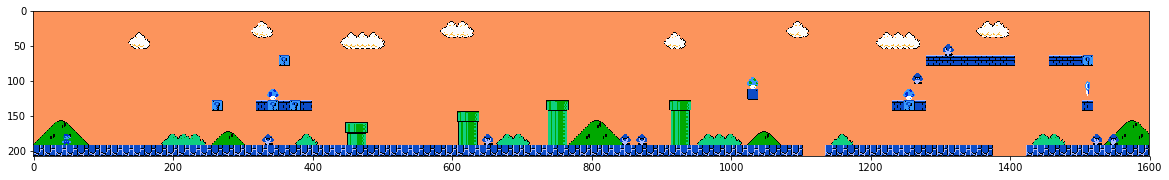

In [17]:

levelStr = [['-' for xx in range(maxX+1)] for yy in range(maxY+1)] 
for loc,tile in levelMap.items():
    levelStr[loc[1]][loc[0]] = tile
for line in levelStr:
    print ''.join([legend[l] for l in line][:100])
    
    
plt.figure(figsize=(20,20))
plt.imshow(level[:,:100*16,:])
plt.show()

